# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [7]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [8]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [9]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [10]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.4625383999909856 -2.758558421102158
actions: 1 0
rewards: 1.0 1.0


In [11]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [12]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [14]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [15]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [16]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, reward, training

In [17]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [18]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [19]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward, training): # model input
    # PG
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss_p = tf.reduce_mean(neg_log_prob_actions * targetQs) * reward 
    #Qs_label = tf.reshape(0.01*targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    #Qs_label = tf.reshape(tf.nn.sigmoid(targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    #g_loss_p = tf.reduce_mean(neg_log_prob_actions * Qs_label) * reward 
    # reward/rate = episode_total_reward/goal_total_reward --> success/fail rate of episode
    
    # AT
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    # QN
    g_loss_q = tf.reduce_mean(tf.square(Qs_logits[:-1]-targetQs[1:]))
    #g_loss_q = tf.reduce_mean(tf.square(Qs_logits[:-1]-Qs_label))
    # g_loss_q = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
    #                                                                   labels=tf.nn.sigmoid(Qs_label)))
    g_loss = g_loss_p + g_loss_q
    return actions_logits, Qs_logits, g_loss, d_loss, g_loss_p, g_loss_q

In [20]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward, self.training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_loss_p, self.g_loss_q = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, reward=self.reward, targetQs=self.targetQs, 
            training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [22]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [23]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [26]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1]),
                                                                      model.training: False})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            Q_logits = sess.run(model.Qs_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                            model.actions: np.array([action]), 
                                                            model.training: False})
            targetQ = Q_logits * (1-float(done))
            batch.append([state, action, targetQ])
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # success criteria
                success_rate = total_reward/100 # success rate
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, g_loss_p, g_loss_q, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                             model.g_loss_p, model.g_loss_q, 
                                                             model.g_opt, model.d_opt],
                                                            feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.reward: success_rate,
                                                                         model.targetQs: targetQs.reshape([-1]),
                                                                         model.training: False}) #????????????
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              #'stdR:{:.4f}'.format(np.std(episodes_total_reward)),
              'glossP:{:.4f}'.format(g_loss_p),
              'glossQ:{:.4f}'.format(g_loss_q),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) > 100:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 glossP:0.0077 glossQ:0.0237 gloss:0.0314 dloss:0.7734
Episode:1 meanR:10.0000 glossP:0.0049 glossQ:0.0132 gloss:0.0181 dloss:0.7473
Episode:2 meanR:10.0000 glossP:0.0023 glossQ:0.0055 gloss:0.0079 dloss:0.7211
Episode:3 meanR:10.2500 glossP:0.0001 glossQ:0.0014 gloss:0.0015 dloss:0.6979
Episode:4 meanR:10.4000 glossP:-0.0025 glossQ:0.0003 gloss:-0.0022 dloss:0.6738
Episode:5 meanR:10.1667 glossP:-0.0040 glossQ:0.0019 gloss:-0.0021 dloss:0.6519
Episode:6 meanR:10.1429 glossP:-0.0068 glossQ:0.0063 gloss:-0.0005 dloss:0.6314
Episode:7 meanR:10.0000 glossP:-0.0082 glossQ:0.0125 gloss:0.0043 dloss:0.6111
Episode:8 meanR:10.0000 glossP:-0.0123 glossQ:0.0230 gloss:0.0107 dloss:0.5936
Episode:9 meanR:10.0000 glossP:-0.0153 glossQ:0.0328 gloss:0.0175 dloss:0.5773
Episode:10 meanR:10.0000 glossP:-0.0191 glossQ:0.0447 gloss:0.0256 dloss:0.5617
Episode:11 meanR:9.9167 glossP:-0.0203 glossQ:0.0540 gloss:0.0337 dloss:0.5444
Episode:12 meanR:13.2308 glossP:-0.0807 glossQ:0.027

Episode:106 meanR:30.0800 glossP:-0.1498 glossQ:0.0449 gloss:-0.1048 dloss:0.5942
Episode:107 meanR:30.2700 glossP:-0.1486 glossQ:0.0453 gloss:-0.1033 dloss:0.5943
Episode:108 meanR:30.4500 glossP:-0.1456 glossQ:0.0422 gloss:-0.1034 dloss:0.5945
Episode:109 meanR:30.6100 glossP:-0.1367 glossQ:0.0481 gloss:-0.0886 dloss:0.5774
Episode:110 meanR:30.8500 glossP:-0.1761 glossQ:0.0401 gloss:-0.1359 dloss:0.6452
Episode:111 meanR:31.0400 glossP:-0.1487 glossQ:0.0497 gloss:-0.0990 dloss:0.5950
Episode:112 meanR:30.7200 glossP:-0.1154 glossQ:0.0666 gloss:-0.0488 dloss:0.5321
Episode:113 meanR:30.4600 glossP:-0.1301 glossQ:0.0951 gloss:-0.0350 dloss:0.5260
Episode:114 meanR:30.2300 glossP:-0.1164 glossQ:0.1390 gloss:0.0225 dloss:0.4777
Episode:115 meanR:29.9600 glossP:-0.0959 glossQ:0.2059 gloss:0.1100 dloss:0.4237
Episode:116 meanR:29.7500 glossP:-0.1052 glossQ:0.2771 gloss:0.1719 dloss:0.4113
Episode:117 meanR:29.4100 glossP:-0.1606 glossQ:0.2418 gloss:0.0812 dloss:0.4770
Episode:118 meanR:29

Episode:213 meanR:29.6800 glossP:-0.0312 glossQ:0.0740 gloss:0.0428 dloss:0.4724
Episode:214 meanR:29.6100 glossP:-0.0317 glossQ:0.0822 gloss:0.0505 dloss:0.4705
Episode:215 meanR:29.5700 glossP:-0.0278 glossQ:0.0880 gloss:0.0603 dloss:0.4665
Episode:216 meanR:29.5500 glossP:-0.0396 glossQ:0.1370 gloss:0.0974 dloss:0.4630
Episode:217 meanR:29.4600 glossP:-0.0305 glossQ:0.1264 gloss:0.0960 dloss:0.4528
Episode:218 meanR:29.3700 glossP:-0.0384 glossQ:0.1802 gloss:0.1418 dloss:0.4441
Episode:219 meanR:29.2700 glossP:-0.0282 glossQ:0.1572 gloss:0.1290 dloss:0.4333
Episode:220 meanR:29.1800 glossP:-0.0376 glossQ:0.2289 gloss:0.1913 dloss:0.4238
Episode:221 meanR:29.1000 glossP:-0.0412 glossQ:0.2801 gloss:0.2389 dloss:0.4113
Episode:222 meanR:28.9800 glossP:-0.0459 glossQ:0.3557 gloss:0.3098 dloss:0.3987
Episode:223 meanR:28.9200 glossP:-0.0522 glossQ:0.4394 gloss:0.3871 dloss:0.3862
Episode:224 meanR:28.8100 glossP:-0.0606 glossQ:0.5510 gloss:0.4905 dloss:0.3770
Episode:225 meanR:28.7300 gl

Episode:314 meanR:26.0700 glossP:-0.1679 glossQ:0.0901 gloss:-0.0778 dloss:0.5958
Episode:315 meanR:26.3200 glossP:-0.1932 glossQ:0.0756 gloss:-0.1176 dloss:0.6502
Episode:316 meanR:26.4400 glossP:-0.1263 glossQ:0.0754 gloss:-0.0509 dloss:0.5505
Episode:317 meanR:26.6400 glossP:-0.1531 glossQ:0.0619 gloss:-0.0911 dloss:0.6043
Episode:318 meanR:26.8500 glossP:-0.1601 glossQ:0.0571 gloss:-0.1030 dloss:0.6211
Episode:319 meanR:27.0600 glossP:-0.1444 glossQ:0.0522 gloss:-0.0922 dloss:0.6046
Episode:320 meanR:27.2700 glossP:-0.1447 glossQ:0.0432 gloss:-0.1015 dloss:0.6128
Episode:321 meanR:27.4100 glossP:-0.1079 glossQ:0.0527 gloss:-0.0552 dloss:0.5595
Episode:322 meanR:27.5100 glossP:-0.0938 glossQ:0.0641 gloss:-0.0297 dloss:0.5230
Episode:323 meanR:27.7400 glossP:-0.1639 glossQ:0.0547 gloss:-0.1092 dloss:0.6291
Episode:324 meanR:27.9800 glossP:-0.1850 glossQ:0.0618 gloss:-0.1232 dloss:0.6405
Episode:325 meanR:28.0800 glossP:-0.1194 glossQ:0.0845 gloss:-0.0349 dloss:0.5295
Episode:326 mean

Episode:416 meanR:28.7200 glossP:-0.1177 glossQ:0.0402 gloss:-0.0775 dloss:0.5749
Episode:417 meanR:28.6800 glossP:-0.1280 glossQ:0.0479 gloss:-0.0801 dloss:0.5710
Episode:418 meanR:28.6000 glossP:-0.1322 glossQ:0.0672 gloss:-0.0650 dloss:0.5483
Episode:419 meanR:28.6300 glossP:-0.1923 glossQ:0.0633 gloss:-0.1290 dloss:0.6325
Episode:420 meanR:28.5300 glossP:-0.1255 glossQ:0.1020 gloss:-0.0234 dloss:0.5159
Episode:421 meanR:28.6300 glossP:-0.2121 glossQ:0.0822 gloss:-0.1299 dloss:0.6461
Episode:422 meanR:28.7600 glossP:-0.2152 glossQ:0.0983 gloss:-0.1169 dloss:0.6398
Episode:423 meanR:28.7100 glossP:-0.1879 glossQ:0.1141 gloss:-0.0738 dloss:0.5881
Episode:424 meanR:28.7500 glossP:-0.2596 glossQ:0.1006 gloss:-0.1590 dloss:0.6991
Episode:425 meanR:28.8300 glossP:-0.1941 glossQ:0.0958 gloss:-0.0983 dloss:0.6078
Episode:426 meanR:28.8600 glossP:-0.1637 glossQ:0.0783 gloss:-0.0854 dloss:0.5856
Episode:427 meanR:28.7500 glossP:-0.1096 glossQ:0.0734 gloss:-0.0362 dloss:0.5256
Episode:428 mean

Episode:519 meanR:30.6700 glossP:-0.0700 glossQ:0.0247 gloss:-0.0453 dloss:0.5622
Episode:520 meanR:30.7200 glossP:-0.1064 glossQ:0.0337 gloss:-0.0727 dloss:0.5804
Episode:521 meanR:30.7000 glossP:-0.1470 glossQ:0.0407 gloss:-0.1064 dloss:0.6207
Episode:522 meanR:30.7000 glossP:-0.1713 glossQ:0.0612 gloss:-0.1101 dloss:0.6298
Episode:523 meanR:30.8100 glossP:-0.2355 glossQ:0.0798 gloss:-0.1558 dloss:0.6932
Episode:524 meanR:30.7800 glossP:-0.2219 glossQ:0.0930 gloss:-0.1289 dloss:0.6581
Episode:525 meanR:30.7900 glossP:-0.2093 glossQ:0.0956 gloss:-0.1137 dloss:0.6203
Episode:526 meanR:30.7800 glossP:-0.1780 glossQ:0.0967 gloss:-0.0813 dloss:0.5761
Episode:527 meanR:30.8600 glossP:-0.1810 glossQ:0.0769 gloss:-0.1041 dloss:0.5960
Episode:528 meanR:30.7600 glossP:-0.1309 glossQ:0.0771 gloss:-0.0539 dloss:0.5369
Episode:529 meanR:30.8600 glossP:-0.1885 glossQ:0.0487 gloss:-0.1398 dloss:0.6618
Episode:530 meanR:30.8600 glossP:-0.1400 glossQ:0.0378 gloss:-0.1022 dloss:0.6210
Episode:531 mean

Episode:619 meanR:30.5500 glossP:-0.1538 glossQ:0.0476 gloss:-0.1061 dloss:0.6207
Episode:620 meanR:30.6300 glossP:-0.1614 glossQ:0.0481 gloss:-0.1134 dloss:0.6363
Episode:621 meanR:30.7500 glossP:-0.2064 glossQ:0.0415 gloss:-0.1649 dloss:0.7129
Episode:622 meanR:30.8200 glossP:-0.1849 glossQ:0.0429 gloss:-0.1420 dloss:0.6815
Episode:623 meanR:30.8600 glossP:-0.1994 glossQ:0.0419 gloss:-0.1575 dloss:0.7044
Episode:624 meanR:30.7400 glossP:-0.1072 glossQ:0.0545 gloss:-0.0527 dloss:0.5496
Episode:625 meanR:30.7600 glossP:-0.1528 glossQ:0.0370 gloss:-0.1158 dloss:0.6280
Episode:626 meanR:30.7300 glossP:-0.1100 glossQ:0.0463 gloss:-0.0638 dloss:0.5573
Episode:627 meanR:30.6300 glossP:-0.0854 glossQ:0.0556 gloss:-0.0298 dloss:0.5171
Episode:628 meanR:30.6100 glossP:-0.1028 glossQ:0.0647 gloss:-0.0381 dloss:0.5290
Episode:629 meanR:30.6700 glossP:-0.2241 glossQ:0.0537 gloss:-0.1704 dloss:0.7151
Episode:630 meanR:30.7400 glossP:-0.2069 glossQ:0.0629 gloss:-0.1440 dloss:0.6829
Episode:631 mean

Episode:721 meanR:30.1500 glossP:-0.1493 glossQ:0.0411 gloss:-0.1081 dloss:0.6205
Episode:722 meanR:30.2600 glossP:-0.2209 glossQ:0.0251 gloss:-0.1958 dloss:0.7539
Episode:723 meanR:30.1100 glossP:-0.1175 glossQ:0.0326 gloss:-0.0849 dloss:0.5928
Episode:724 meanR:30.1800 glossP:-0.1193 glossQ:0.0265 gloss:-0.0928 dloss:0.6089
Episode:725 meanR:30.0200 glossP:-0.0661 glossQ:0.0422 gloss:-0.0239 dloss:0.5182
Episode:726 meanR:29.9800 glossP:-0.0845 glossQ:0.0456 gloss:-0.0388 dloss:0.5345
Episode:727 meanR:30.2000 glossP:-0.1818 glossQ:0.0303 gloss:-0.1515 dloss:0.6859
Episode:728 meanR:30.3600 glossP:-0.1753 glossQ:0.0428 gloss:-0.1325 dloss:0.6594
Episode:729 meanR:30.3900 glossP:-0.2289 glossQ:0.0435 gloss:-0.1855 dloss:0.7337
Episode:730 meanR:30.3400 glossP:-0.1684 glossQ:0.0517 gloss:-0.1166 dloss:0.6369
Episode:731 meanR:30.3000 glossP:-0.1806 glossQ:0.0672 gloss:-0.1134 dloss:0.6229
Episode:732 meanR:30.2600 glossP:-0.1413 glossQ:0.0818 gloss:-0.0595 dloss:0.5456
Episode:733 mean

Episode:823 meanR:30.4400 glossP:-0.1561 glossQ:0.0540 gloss:-0.1021 dloss:0.6125
Episode:824 meanR:30.6600 glossP:-0.2529 glossQ:0.0390 gloss:-0.2139 dloss:0.7774
Episode:825 meanR:30.7400 glossP:-0.1197 glossQ:0.0538 gloss:-0.0659 dloss:0.5651
Episode:826 meanR:30.7900 glossP:-0.1198 glossQ:0.0515 gloss:-0.0683 dloss:0.5647
Episode:827 meanR:30.6300 glossP:-0.1188 glossQ:0.0501 gloss:-0.0686 dloss:0.5651
Episode:828 meanR:30.5200 glossP:-0.1263 glossQ:0.0502 gloss:-0.0761 dloss:0.5718
Episode:829 meanR:30.3300 glossP:-0.1349 glossQ:0.0538 gloss:-0.0810 dloss:0.5792
Episode:830 meanR:30.3900 glossP:-0.2105 glossQ:0.0493 gloss:-0.1612 dloss:0.6901
Episode:831 meanR:30.5400 glossP:-0.2341 glossQ:0.0378 gloss:-0.1963 dloss:0.7435
Episode:832 meanR:30.6100 glossP:-0.1566 glossQ:0.0491 gloss:-0.1075 dloss:0.6122
Episode:833 meanR:30.6600 glossP:-0.1214 glossQ:0.0589 gloss:-0.0625 dloss:0.5527
Episode:834 meanR:30.5300 glossP:-0.1071 glossQ:0.0646 gloss:-0.0425 dloss:0.5260
Episode:835 mean

Episode:923 meanR:31.0300 glossP:-0.2155 glossQ:0.0514 gloss:-0.1641 dloss:0.6927
Episode:924 meanR:30.8300 glossP:-0.1694 glossQ:0.0528 gloss:-0.1166 dloss:0.6213
Episode:925 meanR:30.7700 glossP:-0.0935 glossQ:0.0667 gloss:-0.0268 dloss:0.5077
Episode:926 meanR:30.7200 glossP:-0.0965 glossQ:0.0647 gloss:-0.0318 dloss:0.5201
Episode:927 meanR:30.7700 glossP:-0.1468 glossQ:0.0512 gloss:-0.0956 dloss:0.6045
Episode:928 meanR:30.9800 glossP:-0.2169 glossQ:0.0378 gloss:-0.1791 dloss:0.7336
Episode:929 meanR:31.4200 glossP:-0.3157 glossQ:0.0268 gloss:-0.2890 dloss:0.9035
Episode:930 meanR:31.3500 glossP:-0.1392 glossQ:0.0353 gloss:-0.1038 dloss:0.6284
Episode:931 meanR:31.0900 glossP:-0.0827 glossQ:0.0379 gloss:-0.0448 dloss:0.5480
Episode:932 meanR:31.0700 glossP:-0.1093 glossQ:0.0236 gloss:-0.0857 dloss:0.6034
Episode:933 meanR:31.0800 glossP:-0.0932 glossQ:0.0263 gloss:-0.0668 dloss:0.5781
Episode:934 meanR:31.0700 glossP:-0.0762 glossQ:0.0368 gloss:-0.0394 dloss:0.5420
Episode:935 mean

Episode:1025 meanR:31.4900 glossP:-0.1936 glossQ:0.0571 gloss:-0.1365 dloss:0.6573
Episode:1026 meanR:31.5200 glossP:-0.1226 glossQ:0.0701 gloss:-0.0525 dloss:0.5406
Episode:1027 meanR:31.3900 glossP:-0.0885 glossQ:0.0867 gloss:-0.0018 dloss:0.4821
Episode:1028 meanR:31.1800 glossP:-0.1390 glossQ:0.0664 gloss:-0.0726 dloss:0.5676
Episode:1029 meanR:30.8300 glossP:-0.1905 glossQ:0.0558 gloss:-0.1347 dloss:0.6565
Episode:1030 meanR:30.8200 glossP:-0.1563 glossQ:0.0518 gloss:-0.1045 dloss:0.6207
Episode:1031 meanR:30.9300 glossP:-0.1523 glossQ:0.0509 gloss:-0.1013 dloss:0.6207
Episode:1032 meanR:30.9700 glossP:-0.1619 glossQ:0.0510 gloss:-0.1109 dloss:0.6291
Episode:1033 meanR:31.1300 glossP:-0.2030 glossQ:0.0480 gloss:-0.1551 dloss:0.6944
Episode:1034 meanR:31.2200 glossP:-0.1478 glossQ:0.0654 gloss:-0.0824 dloss:0.5960
Episode:1035 meanR:31.2400 glossP:-0.1202 glossQ:0.0679 gloss:-0.0523 dloss:0.5532
Episode:1036 meanR:31.2200 glossP:-0.1463 glossQ:0.0629 gloss:-0.0834 dloss:0.5864
Epis

Episode:1126 meanR:30.6400 glossP:-0.1164 glossQ:0.0423 gloss:-0.0741 dloss:0.5955
Episode:1127 meanR:30.8600 glossP:-0.1697 glossQ:0.0442 gloss:-0.1254 dloss:0.6705
Episode:1128 meanR:30.9800 glossP:-0.1686 glossQ:0.0466 gloss:-0.1220 dloss:0.6647
Episode:1129 meanR:31.0800 glossP:-0.2259 glossQ:0.0560 gloss:-0.1699 dloss:0.7308
Episode:1130 meanR:31.0200 glossP:-0.1467 glossQ:0.0807 gloss:-0.0659 dloss:0.5668
Episode:1131 meanR:30.9300 glossP:-0.1361 glossQ:0.0932 gloss:-0.0430 dloss:0.5354
Episode:1132 meanR:30.8400 glossP:-0.1428 glossQ:0.0932 gloss:-0.0496 dloss:0.5451
Episode:1133 meanR:30.7200 glossP:-0.1771 glossQ:0.0882 gloss:-0.0889 dloss:0.5961
Episode:1134 meanR:30.8200 glossP:-0.2313 glossQ:0.0796 gloss:-0.1517 dloss:0.6926
Episode:1135 meanR:30.9200 glossP:-0.2005 glossQ:0.0787 gloss:-0.1218 dloss:0.6448
Episode:1136 meanR:30.9800 glossP:-0.1930 glossQ:0.0724 gloss:-0.1206 dloss:0.6427
Episode:1137 meanR:30.9300 glossP:-0.1472 glossQ:0.0649 gloss:-0.0823 dloss:0.5960
Epis

Episode:1225 meanR:30.7000 glossP:-0.1900 glossQ:0.0449 gloss:-0.1451 dloss:0.6701
Episode:1226 meanR:30.7200 glossP:-0.1470 glossQ:0.0482 gloss:-0.0988 dloss:0.6042
Episode:1227 meanR:30.6500 glossP:-0.1503 glossQ:0.0416 gloss:-0.1087 dloss:0.6204
Episode:1228 meanR:30.5800 glossP:-0.1422 glossQ:0.0416 gloss:-0.1006 dloss:0.6129
Episode:1229 meanR:30.3900 glossP:-0.1208 glossQ:0.0399 gloss:-0.0809 dloss:0.5829
Episode:1230 meanR:30.4100 glossP:-0.1234 glossQ:0.0395 gloss:-0.0839 dloss:0.5913
Episode:1231 meanR:30.4000 glossP:-0.0934 glossQ:0.0462 gloss:-0.0471 dloss:0.5487
Episode:1232 meanR:30.5300 glossP:-0.1582 glossQ:0.0332 gloss:-0.1250 dloss:0.6564
Episode:1233 meanR:30.7300 glossP:-0.2083 glossQ:0.0291 gloss:-0.1792 dloss:0.7390
Episode:1234 meanR:30.6500 glossP:-0.1306 glossQ:0.0359 gloss:-0.0947 dloss:0.6143
Episode:1235 meanR:30.6600 glossP:-0.1488 glossQ:0.0344 gloss:-0.1143 dloss:0.6423
Episode:1236 meanR:30.6300 glossP:-0.1378 glossQ:0.0424 gloss:-0.0955 dloss:0.6136
Epis

Episode:1325 meanR:31.2300 glossP:-0.0725 glossQ:0.0298 gloss:-0.0426 dloss:0.5471
Episode:1326 meanR:31.1700 glossP:-0.0898 glossQ:0.0259 gloss:-0.0638 dloss:0.5711
Episode:1327 meanR:31.1600 glossP:-0.1221 glossQ:0.0238 gloss:-0.0984 dloss:0.6155
Episode:1328 meanR:31.0800 glossP:-0.0940 glossQ:0.0355 gloss:-0.0584 dloss:0.5587
Episode:1329 meanR:31.1800 glossP:-0.1498 glossQ:0.0282 gloss:-0.1216 dloss:0.6552
Episode:1330 meanR:31.2900 glossP:-0.1727 glossQ:0.0390 gloss:-0.1337 dloss:0.6710
Episode:1331 meanR:31.5000 glossP:-0.1885 glossQ:0.0360 gloss:-0.1526 dloss:0.6977
Episode:1332 meanR:31.5000 glossP:-0.1791 glossQ:0.0493 gloss:-0.1298 dloss:0.6596
Episode:1333 meanR:31.2300 glossP:-0.1165 glossQ:0.0687 gloss:-0.0478 dloss:0.5308
Episode:1334 meanR:31.1400 glossP:-0.1196 glossQ:0.0743 gloss:-0.0453 dloss:0.5289
Episode:1335 meanR:31.1200 glossP:-0.1708 glossQ:0.0595 gloss:-0.1112 dloss:0.6295
Episode:1336 meanR:31.2600 glossP:-0.2229 glossQ:0.0488 gloss:-0.1741 dloss:0.7231
Epis

Episode:1424 meanR:31.5000 glossP:-0.0625 glossQ:0.0168 gloss:-0.0457 dloss:0.5708
Episode:1425 meanR:31.5300 glossP:-0.0749 glossQ:0.0195 gloss:-0.0555 dloss:0.5747
Episode:1426 meanR:31.4900 glossP:-0.0722 glossQ:0.0310 gloss:-0.0412 dloss:0.5465
Episode:1427 meanR:31.5000 glossP:-0.1334 glossQ:0.0305 gloss:-0.1030 dloss:0.6211
Episode:1428 meanR:31.5500 glossP:-0.1343 glossQ:0.0475 gloss:-0.0868 dloss:0.5880
Episode:1429 meanR:31.5000 glossP:-0.1665 glossQ:0.0559 gloss:-0.1106 dloss:0.6214
Episode:1430 meanR:31.5200 glossP:-0.1819 glossQ:0.0603 gloss:-0.1216 dloss:0.6859
Episode:1431 meanR:31.6900 glossP:-0.2954 glossQ:0.0821 gloss:-0.2133 dloss:0.8361
Episode:1432 meanR:31.7400 glossP:-0.2312 glossQ:0.1100 gloss:-0.1212 dloss:0.7125
Episode:1433 meanR:31.7700 glossP:-0.1515 glossQ:0.0958 gloss:-0.0557 dloss:0.5553
Episode:1434 meanR:31.7900 glossP:-0.1457 glossQ:0.0961 gloss:-0.0496 dloss:0.5442
Episode:1435 meanR:31.7400 glossP:-0.1703 glossQ:0.0841 gloss:-0.0862 dloss:0.5859
Epis

Episode:1526 meanR:30.9600 glossP:-0.1340 glossQ:0.0480 gloss:-0.0860 dloss:0.5887
Episode:1527 meanR:30.8900 glossP:-0.1189 glossQ:0.0541 gloss:-0.0649 dloss:0.5643
Episode:1528 meanR:30.9000 glossP:-0.1400 glossQ:0.0512 gloss:-0.0888 dloss:0.5965
Episode:1529 meanR:30.8900 glossP:-0.1529 glossQ:0.0520 gloss:-0.1009 dloss:0.6125
Episode:1530 meanR:30.8900 glossP:-0.1945 glossQ:0.0374 gloss:-0.1571 dloss:0.6914
Episode:1531 meanR:30.6500 glossP:-0.1805 glossQ:0.0492 gloss:-0.1313 dloss:0.6534
Episode:1532 meanR:30.6200 glossP:-0.1989 glossQ:0.0482 gloss:-0.1508 dloss:0.6789
Episode:1533 meanR:30.6500 glossP:-0.1422 glossQ:0.0553 gloss:-0.0869 dloss:0.5873
Episode:1534 meanR:30.6500 glossP:-0.1234 glossQ:0.0604 gloss:-0.0630 dloss:0.5504
Episode:1535 meanR:30.7100 glossP:-0.1765 glossQ:0.0512 gloss:-0.1253 dloss:0.6382
Episode:1536 meanR:30.7700 glossP:-0.1505 glossQ:0.0528 gloss:-0.0977 dloss:0.5949
Episode:1537 meanR:30.7500 glossP:-0.1183 glossQ:0.0616 gloss:-0.0568 dloss:0.5415
Epis

Episode:1625 meanR:31.2900 glossP:-0.1731 glossQ:0.0453 gloss:-0.1278 dloss:0.6517
Episode:1626 meanR:31.3700 glossP:-0.1747 glossQ:0.0432 gloss:-0.1316 dloss:0.6526
Episode:1627 meanR:31.4000 glossP:-0.1351 glossQ:0.0493 gloss:-0.0857 dloss:0.5877
Episode:1628 meanR:31.3300 glossP:-0.1046 glossQ:0.0570 gloss:-0.0475 dloss:0.5381
Episode:1629 meanR:31.2800 glossP:-0.1253 glossQ:0.0520 gloss:-0.0733 dloss:0.5719
Episode:1630 meanR:31.3300 glossP:-0.2041 glossQ:0.0395 gloss:-0.1646 dloss:0.7204
Episode:1631 meanR:31.3300 glossP:-0.1564 glossQ:0.0419 gloss:-0.1145 dloss:0.6497
Episode:1632 meanR:31.3200 glossP:-0.1787 glossQ:0.0453 gloss:-0.1334 dloss:0.6665
Episode:1633 meanR:31.3500 glossP:-0.1498 glossQ:0.0473 gloss:-0.1025 dloss:0.6126
Episode:1634 meanR:31.4200 glossP:-0.1453 glossQ:0.0504 gloss:-0.0949 dloss:0.6132
Episode:1635 meanR:31.4200 glossP:-0.1626 glossQ:0.0457 gloss:-0.1169 dloss:0.6364
Episode:1636 meanR:31.3400 glossP:-0.1005 glossQ:0.0588 gloss:-0.0416 dloss:0.5298
Epis

Episode:1724 meanR:30.7900 glossP:-0.1372 glossQ:0.0461 gloss:-0.0911 dloss:0.5966
Episode:1725 meanR:30.8500 glossP:-0.1863 glossQ:0.0283 gloss:-0.1580 dloss:0.6926
Episode:1726 meanR:30.8300 glossP:-0.1477 glossQ:0.0353 gloss:-0.1123 dloss:0.6353
Episode:1727 meanR:30.9500 glossP:-0.1797 glossQ:0.0331 gloss:-0.1466 dloss:0.6784
Episode:1728 meanR:31.0900 glossP:-0.1659 glossQ:0.0316 gloss:-0.1343 dloss:0.6503
Episode:1729 meanR:31.0300 glossP:-0.0887 glossQ:0.0461 gloss:-0.0426 dloss:0.5271
Episode:1730 meanR:30.8300 glossP:-0.1143 glossQ:0.0387 gloss:-0.0756 dloss:0.5757
Episode:1731 meanR:30.9200 glossP:-0.1870 glossQ:0.0267 gloss:-0.1603 dloss:0.7082
Episode:1732 meanR:30.9300 glossP:-0.1636 glossQ:0.0313 gloss:-0.1323 dloss:0.6690
Episode:1733 meanR:30.9800 glossP:-0.1463 glossQ:0.0260 gloss:-0.1203 dloss:0.6484
Episode:1734 meanR:31.0200 glossP:-0.1511 glossQ:0.0325 gloss:-0.1186 dloss:0.6423
Episode:1735 meanR:30.9200 glossP:-0.1019 glossQ:0.0390 gloss:-0.0629 dloss:0.5627
Epis

Episode:1825 meanR:32.6200 glossP:-0.1834 glossQ:0.0460 gloss:-0.1374 dloss:0.6533
Episode:1826 meanR:32.5400 glossP:-0.1349 glossQ:0.0526 gloss:-0.0824 dloss:0.5682
Episode:1827 meanR:32.4200 glossP:-0.1447 glossQ:0.0483 gloss:-0.0964 dloss:0.5860
Episode:1828 meanR:32.2900 glossP:-0.1166 glossQ:0.0560 gloss:-0.0606 dloss:0.5422
Episode:1829 meanR:32.3600 glossP:-0.1340 glossQ:0.0517 gloss:-0.0823 dloss:0.5794
Episode:1830 meanR:32.3900 glossP:-0.1418 glossQ:0.0493 gloss:-0.0925 dloss:0.5965
Episode:1831 meanR:32.3500 glossP:-0.1943 glossQ:0.0397 gloss:-0.1546 dloss:0.6892
Episode:1832 meanR:32.3000 glossP:-0.1559 glossQ:0.0420 gloss:-0.1139 dloss:0.6356
Episode:1833 meanR:32.4600 glossP:-0.2356 glossQ:0.0321 gloss:-0.2035 dloss:0.7664
Episode:1834 meanR:32.4800 glossP:-0.1808 glossQ:0.0429 gloss:-0.1379 dloss:0.6597
Episode:1835 meanR:32.6000 glossP:-0.1760 glossQ:0.0400 gloss:-0.1360 dloss:0.6519
Episode:1836 meanR:32.2700 glossP:-0.1409 glossQ:0.0424 gloss:-0.0985 dloss:0.5958
Epis

Episode:1928 meanR:31.9300 glossP:-0.1061 glossQ:0.0520 gloss:-0.0541 dloss:0.5368
Episode:1929 meanR:32.0000 glossP:-0.1630 glossQ:0.0423 gloss:-0.1207 dloss:0.6359
Episode:1930 meanR:32.1200 glossP:-0.1936 glossQ:0.0396 gloss:-0.1540 dloss:0.6882
Episode:1931 meanR:32.0100 glossP:-0.1326 glossQ:0.0407 gloss:-0.0919 dloss:0.6067
Episode:1932 meanR:32.0900 glossP:-0.1908 glossQ:0.0373 gloss:-0.1535 dloss:0.6935
Episode:1933 meanR:31.9000 glossP:-0.1514 glossQ:0.0429 gloss:-0.1084 dloss:0.6283
Episode:1934 meanR:31.9400 glossP:-0.1897 glossQ:0.0364 gloss:-0.1533 dloss:0.6871
Episode:1935 meanR:31.8800 glossP:-0.1403 glossQ:0.0410 gloss:-0.0993 dloss:0.6051
Episode:1936 meanR:31.8100 glossP:-0.1014 glossQ:0.0471 gloss:-0.0543 dloss:0.5403
Episode:1937 meanR:31.7000 glossP:-0.1021 glossQ:0.0474 gloss:-0.0546 dloss:0.5402
Episode:1938 meanR:31.8300 glossP:-0.1536 glossQ:0.0395 gloss:-0.1141 dloss:0.6280
Episode:1939 meanR:31.9400 glossP:-0.1265 glossQ:0.0434 gloss:-0.0831 dloss:0.5917
Epis

Episode:2028 meanR:32.2000 glossP:-0.1047 glossQ:0.0552 gloss:-0.0494 dloss:0.5372
Episode:2029 meanR:32.1800 glossP:-0.1569 glossQ:0.0447 gloss:-0.1122 dloss:0.6204
Episode:2030 meanR:32.1500 glossP:-0.1897 glossQ:0.0435 gloss:-0.1462 dloss:0.6692
Episode:2031 meanR:32.1400 glossP:-0.1427 glossQ:0.0481 gloss:-0.0945 dloss:0.5956
Episode:2032 meanR:31.9900 glossP:-0.1297 glossQ:0.0497 gloss:-0.0800 dloss:0.5798
Episode:2033 meanR:32.0400 glossP:-0.1851 glossQ:0.0426 gloss:-0.1426 dloss:0.6677
Episode:2034 meanR:31.9900 glossP:-0.1769 glossQ:0.0452 gloss:-0.1317 dloss:0.6524
Episode:2035 meanR:31.9900 glossP:-0.1430 glossQ:0.0465 gloss:-0.0965 dloss:0.6049
Episode:2036 meanR:32.0300 glossP:-0.1258 glossQ:0.0495 gloss:-0.0763 dloss:0.5720
Episode:2037 meanR:32.1200 glossP:-0.1490 glossQ:0.0474 gloss:-0.1016 dloss:0.6127
Episode:2038 meanR:32.0800 glossP:-0.1373 glossQ:0.0476 gloss:-0.0896 dloss:0.5971
Episode:2039 meanR:32.0800 glossP:-0.1357 glossQ:0.0494 gloss:-0.0863 dloss:0.5884
Epis

Episode:2129 meanR:32.2600 glossP:-0.1541 glossQ:0.0355 gloss:-0.1186 dloss:0.6496
Episode:2130 meanR:32.2000 glossP:-0.1397 glossQ:0.0395 gloss:-0.1001 dloss:0.6209
Episode:2131 meanR:32.2800 glossP:-0.1623 glossQ:0.0369 gloss:-0.1254 dloss:0.6574
Episode:2132 meanR:32.3400 glossP:-0.1404 glossQ:0.0348 gloss:-0.1056 dloss:0.6281
Episode:2133 meanR:32.3100 glossP:-0.1567 glossQ:0.0386 gloss:-0.1180 dloss:0.6430
Episode:2134 meanR:32.2400 glossP:-0.1277 glossQ:0.0410 gloss:-0.0867 dloss:0.5981
Episode:2135 meanR:32.2100 glossP:-0.1201 glossQ:0.0429 gloss:-0.0772 dloss:0.5822
Episode:2136 meanR:32.2200 glossP:-0.1177 glossQ:0.0411 gloss:-0.0766 dloss:0.5833
Episode:2137 meanR:32.1700 glossP:-0.1173 glossQ:0.0448 gloss:-0.0725 dloss:0.5746
Episode:2138 meanR:32.2100 glossP:-0.1477 glossQ:0.0370 gloss:-0.1108 dloss:0.6280
Episode:2139 meanR:32.2400 glossP:-0.1434 glossQ:0.0444 gloss:-0.0989 dloss:0.6127
Episode:2140 meanR:32.2500 glossP:-0.1489 glossQ:0.0441 gloss:-0.1048 dloss:0.6205
Epis

Episode:2228 meanR:31.8100 glossP:-0.1333 glossQ:0.0291 gloss:-0.1042 dloss:0.6485
Episode:2229 meanR:31.7200 glossP:-0.1093 glossQ:0.0368 gloss:-0.0725 dloss:0.5876
Episode:2230 meanR:31.7200 glossP:-0.1325 glossQ:0.0329 gloss:-0.0996 dloss:0.6216
Episode:2231 meanR:31.6500 glossP:-0.1187 glossQ:0.0355 gloss:-0.0831 dloss:0.6098
Episode:2232 meanR:31.5700 glossP:-0.1014 glossQ:0.0434 gloss:-0.0580 dloss:0.5726
Episode:2233 meanR:31.6100 glossP:-0.1664 glossQ:0.0332 gloss:-0.1332 dloss:0.6692
Episode:2234 meanR:31.7100 glossP:-0.1566 glossQ:0.0264 gloss:-0.1301 dloss:0.6676
Episode:2235 meanR:31.7800 glossP:-0.1555 glossQ:0.0380 gloss:-0.1176 dloss:0.6355
Episode:2236 meanR:31.7500 glossP:-0.1090 glossQ:0.0437 gloss:-0.0653 dloss:0.5600
Episode:2237 meanR:31.7600 glossP:-0.1243 glossQ:0.0440 gloss:-0.0803 dloss:0.5824
Episode:2238 meanR:31.6800 glossP:-0.1176 glossQ:0.0506 gloss:-0.0669 dloss:0.5653
Episode:2239 meanR:31.6900 glossP:-0.1580 glossQ:0.0450 gloss:-0.1130 dloss:0.6205
Epis

Episode:2330 meanR:31.5900 glossP:-0.1704 glossQ:0.0533 gloss:-0.1171 dloss:0.6213
Episode:2331 meanR:31.5200 glossP:-0.1205 glossQ:0.0587 gloss:-0.0618 dloss:0.5399
Episode:2332 meanR:31.4700 glossP:-0.1007 glossQ:0.0621 gloss:-0.0386 dloss:0.5156
Episode:2333 meanR:31.4500 glossP:-0.1965 glossQ:0.0495 gloss:-0.1470 dloss:0.6634
Episode:2334 meanR:31.4900 glossP:-0.2080 glossQ:0.0390 gloss:-0.1690 dloss:0.7065
Episode:2335 meanR:31.5400 glossP:-0.1821 glossQ:0.0338 gloss:-0.1482 dloss:0.6734
Episode:2336 meanR:31.6300 glossP:-0.1535 glossQ:0.0391 gloss:-0.1143 dloss:0.6281
Episode:2337 meanR:31.6700 glossP:-0.1486 glossQ:0.0428 gloss:-0.1058 dloss:0.6127
Episode:2338 meanR:31.8500 glossP:-0.2091 glossQ:0.0374 gloss:-0.1717 dloss:0.7059
Episode:2339 meanR:31.7400 glossP:-0.1001 glossQ:0.0522 gloss:-0.0479 dloss:0.5282
Episode:2340 meanR:31.6300 glossP:-0.1211 glossQ:0.0473 gloss:-0.0738 dloss:0.5624
Episode:2341 meanR:31.6600 glossP:-0.1560 glossQ:0.0454 gloss:-0.1106 dloss:0.6205
Epis

Episode:2429 meanR:32.3200 glossP:-0.1609 glossQ:0.0312 gloss:-0.1297 dloss:0.6799
Episode:2430 meanR:32.3300 glossP:-0.1383 glossQ:0.0370 gloss:-0.1013 dloss:0.6289
Episode:2431 meanR:32.4500 glossP:-0.1531 glossQ:0.0377 gloss:-0.1154 dloss:0.6425
Episode:2432 meanR:32.5500 glossP:-0.1454 glossQ:0.0449 gloss:-0.1005 dloss:0.6048
Episode:2433 meanR:32.4000 glossP:-0.1070 glossQ:0.0551 gloss:-0.0519 dloss:0.5360
Episode:2434 meanR:32.2000 glossP:-0.1120 glossQ:0.0541 gloss:-0.0579 dloss:0.5455
Episode:2435 meanR:32.1600 glossP:-0.1801 glossQ:0.0516 gloss:-0.1285 dloss:0.6456
Episode:2436 meanR:32.1800 glossP:-0.1836 glossQ:0.0556 gloss:-0.1280 dloss:0.6465
Episode:2437 meanR:32.2900 glossP:-0.2183 glossQ:0.0499 gloss:-0.1684 dloss:0.7031
Episode:2438 meanR:32.1300 glossP:-0.1381 glossQ:0.0592 gloss:-0.0788 dloss:0.5790
Episode:2439 meanR:32.1900 glossP:-0.1446 glossQ:0.0624 gloss:-0.0822 dloss:0.5772
Episode:2440 meanR:32.2300 glossP:-0.1566 glossQ:0.0590 gloss:-0.0975 dloss:0.5947
Epis

Episode:2529 meanR:32.4500 glossP:-0.1456 glossQ:0.0341 gloss:-0.1114 dloss:0.6610
Episode:2530 meanR:32.4300 glossP:-0.1277 glossQ:0.0359 gloss:-0.0918 dloss:0.6158
Episode:2531 meanR:32.3800 glossP:-0.1313 glossQ:0.0379 gloss:-0.0934 dloss:0.6070
Episode:2532 meanR:32.4100 glossP:-0.1325 glossQ:0.0336 gloss:-0.0989 dloss:0.6294
Episode:2533 meanR:32.4900 glossP:-0.1297 glossQ:0.0403 gloss:-0.0895 dloss:0.6081
Episode:2534 meanR:32.5600 glossP:-0.1432 glossQ:0.0473 gloss:-0.0959 dloss:0.6055
Episode:2535 meanR:32.5300 glossP:-0.1641 glossQ:0.0476 gloss:-0.1165 dloss:0.6206
Episode:2536 meanR:32.4500 glossP:-0.1465 glossQ:0.0575 gloss:-0.0889 dloss:0.5766
Episode:2537 meanR:32.3100 glossP:-0.1566 glossQ:0.0588 gloss:-0.0978 dloss:0.5852
Episode:2538 meanR:32.4000 glossP:-0.2066 glossQ:0.0552 gloss:-0.1514 dloss:0.6584
Episode:2539 meanR:32.4000 glossP:-0.1539 glossQ:0.0653 gloss:-0.0887 dloss:0.5756
Episode:2540 meanR:32.4400 glossP:-0.1861 glossQ:0.0596 gloss:-0.1265 dloss:0.6311
Epis

Episode:2632 meanR:32.2400 glossP:-0.1567 glossQ:0.0626 gloss:-0.0940 dloss:0.5853
Episode:2633 meanR:32.2600 glossP:-0.1705 glossQ:0.0571 gloss:-0.1135 dloss:0.6214
Episode:2634 meanR:32.2700 glossP:-0.1680 glossQ:0.0587 gloss:-0.1093 dloss:0.6128
Episode:2635 meanR:32.4600 glossP:-0.2813 glossQ:0.0496 gloss:-0.2316 dloss:0.7883
Episode:2636 meanR:32.4500 glossP:-0.1425 glossQ:0.0639 gloss:-0.0787 dloss:0.5671
Episode:2637 meanR:32.4500 glossP:-0.1510 glossQ:0.0570 gloss:-0.0940 dloss:0.5855
Episode:2638 meanR:32.4400 glossP:-0.1961 glossQ:0.0543 gloss:-0.1418 dloss:0.6494
Episode:2639 meanR:32.4300 glossP:-0.1352 glossQ:0.0537 gloss:-0.0815 dloss:0.5677
Episode:2640 meanR:32.3800 glossP:-0.1506 glossQ:0.0606 gloss:-0.0901 dloss:0.5852
Episode:2641 meanR:32.3400 glossP:-0.1416 glossQ:0.0549 gloss:-0.0866 dloss:0.5767
Episode:2642 meanR:32.3300 glossP:-0.1568 glossQ:0.0514 gloss:-0.1054 dloss:0.6037
Episode:2643 meanR:32.3500 glossP:-0.1600 glossQ:0.0485 gloss:-0.1115 dloss:0.6206
Epis

Episode:2731 meanR:30.6000 glossP:-0.1054 glossQ:0.0388 gloss:-0.0667 dloss:0.5896
Episode:2732 meanR:30.6200 glossP:-0.1210 glossQ:0.0322 gloss:-0.0889 dloss:0.6093
Episode:2733 meanR:30.6600 glossP:-0.1521 glossQ:0.0339 gloss:-0.1182 dloss:0.6491
Episode:2734 meanR:30.6300 glossP:-0.1161 glossQ:0.0373 gloss:-0.0787 dloss:0.5942
Episode:2735 meanR:30.5100 glossP:-0.1666 glossQ:0.0320 gloss:-0.1346 dloss:0.6694
Episode:2736 meanR:30.5000 glossP:-0.1073 glossQ:0.0398 gloss:-0.0674 dloss:0.5709
Episode:2737 meanR:30.5800 glossP:-0.1635 glossQ:0.0365 gloss:-0.1270 dloss:0.6502
Episode:2738 meanR:30.6200 glossP:-0.1789 glossQ:0.0361 gloss:-0.1428 dloss:0.6723
Episode:2739 meanR:30.7100 glossP:-0.1625 glossQ:0.0364 gloss:-0.1262 dloss:0.6431
Episode:2740 meanR:30.7000 glossP:-0.1277 glossQ:0.0442 gloss:-0.0835 dloss:0.5802
Episode:2741 meanR:30.7800 glossP:-0.1657 glossQ:0.0390 gloss:-0.1267 dloss:0.6435
Episode:2742 meanR:30.7500 glossP:-0.1287 glossQ:0.0450 gloss:-0.0837 dloss:0.5806
Epis

Episode:2831 meanR:30.9800 glossP:-0.1241 glossQ:0.0623 gloss:-0.0617 dloss:0.5482
Episode:2832 meanR:30.8800 glossP:-0.0997 glossQ:0.0607 gloss:-0.0390 dloss:0.5134
Episode:2833 meanR:30.8500 glossP:-0.1672 glossQ:0.0479 gloss:-0.1193 dloss:0.6289
Episode:2834 meanR:30.8600 glossP:-0.1379 glossQ:0.0524 gloss:-0.0855 dloss:0.5973
Episode:2835 meanR:31.0300 glossP:-0.2484 glossQ:0.0277 gloss:-0.2207 dloss:0.7926
Episode:2836 meanR:31.1300 glossP:-0.1577 glossQ:0.0400 gloss:-0.1177 dloss:0.6428
Episode:2837 meanR:31.0700 glossP:-0.1362 glossQ:0.0414 gloss:-0.0948 dloss:0.6060
Episode:2838 meanR:30.9300 glossP:-0.1177 glossQ:0.0484 gloss:-0.0692 dloss:0.5620
Episode:2839 meanR:30.7900 glossP:-0.0927 glossQ:0.0479 gloss:-0.0448 dloss:0.5341
Episode:2840 meanR:30.7500 glossP:-0.1047 glossQ:0.0479 gloss:-0.0568 dloss:0.5496
Episode:2841 meanR:30.7300 glossP:-0.1462 glossQ:0.0377 gloss:-0.1085 dloss:0.6281
Episode:2842 meanR:30.8500 glossP:-0.1750 glossQ:0.0379 gloss:-0.1371 dloss:0.6722
Epis

Episode:2934 meanR:31.6100 glossP:-0.1054 glossQ:0.0452 gloss:-0.0602 dloss:0.5721
Episode:2935 meanR:31.4200 glossP:-0.1598 glossQ:0.0365 gloss:-0.1232 dloss:0.6563
Episode:2936 meanR:31.4600 glossP:-0.1833 glossQ:0.0448 gloss:-0.1385 dloss:0.6730
Episode:2937 meanR:31.4600 glossP:-0.1551 glossQ:0.0566 gloss:-0.0985 dloss:0.6043
Episode:2938 meanR:31.4300 glossP:-0.1175 glossQ:0.0662 gloss:-0.0513 dloss:0.5288
Episode:2939 meanR:31.5100 glossP:-0.1644 glossQ:0.0627 gloss:-0.1017 dloss:0.5946
Episode:2940 meanR:31.5700 glossP:-0.1705 glossQ:0.0669 gloss:-0.1036 dloss:0.5947
Episode:2941 meanR:31.5600 glossP:-0.1893 glossQ:0.0635 gloss:-0.1259 dloss:0.6234
Episode:2942 meanR:31.4200 glossP:-0.1499 glossQ:0.0768 gloss:-0.0731 dloss:0.5553
Episode:2943 meanR:31.2400 glossP:-0.2721 glossQ:0.0547 gloss:-0.2174 dloss:0.7491
Episode:2944 meanR:31.1800 glossP:-0.1902 glossQ:0.0714 gloss:-0.1188 dloss:0.6063
Episode:2945 meanR:31.2000 glossP:-0.1569 glossQ:0.0737 gloss:-0.0832 dloss:0.5642
Epis

Episode:3035 meanR:31.0700 glossP:-0.1063 glossQ:0.0501 gloss:-0.0562 dloss:0.5586
Episode:3036 meanR:30.9100 glossP:-0.1106 glossQ:0.0610 gloss:-0.0496 dloss:0.5462
Episode:3037 meanR:30.8800 glossP:-0.1403 glossQ:0.0630 gloss:-0.0773 dloss:0.5782
Episode:3038 meanR:31.0200 glossP:-0.2064 glossQ:0.0747 gloss:-0.1317 dloss:0.6605
Episode:3039 meanR:31.2000 glossP:-0.2962 glossQ:0.0703 gloss:-0.2258 dloss:0.7761
Episode:3040 meanR:31.1700 glossP:-0.1752 glossQ:0.0984 gloss:-0.0768 dloss:0.5648
Episode:3041 meanR:31.0700 glossP:-0.1445 glossQ:0.1039 gloss:-0.0406 dloss:0.5181
Episode:3042 meanR:31.0700 glossP:-0.1711 glossQ:0.1027 gloss:-0.0684 dloss:0.5532
Episode:3043 meanR:30.9000 glossP:-0.1920 glossQ:0.0928 gloss:-0.0992 dloss:0.5883
Episode:3044 meanR:30.9100 glossP:-0.1998 glossQ:0.0809 gloss:-0.1189 dloss:0.6184
Episode:3045 meanR:31.0000 glossP:-0.2115 glossQ:0.0700 gloss:-0.1415 dloss:0.6547
Episode:3046 meanR:31.1300 glossP:-0.2465 glossQ:0.0563 gloss:-0.1901 dloss:0.7243
Epis

Episode:3138 meanR:29.9000 glossP:-0.2338 glossQ:0.0441 gloss:-0.1898 dloss:0.7387
Episode:3139 meanR:29.8900 glossP:-0.2306 glossQ:0.0440 gloss:-0.1866 dloss:0.7358
Episode:3140 meanR:29.9900 glossP:-0.1731 glossQ:0.0497 gloss:-0.1234 dloss:0.6527
Episode:3141 meanR:30.0700 glossP:-0.1450 glossQ:0.0690 gloss:-0.0760 dloss:0.6056
Episode:3142 meanR:30.1400 glossP:-0.1548 glossQ:0.0603 gloss:-0.0945 dloss:0.6214
Episode:3143 meanR:30.1000 glossP:-0.1064 glossQ:0.0704 gloss:-0.0360 dloss:0.5603
Episode:3144 meanR:30.1500 glossP:-0.1656 glossQ:0.0535 gloss:-0.1122 dloss:0.6514
Episode:3145 meanR:30.0200 glossP:-0.0912 glossQ:0.0643 gloss:-0.0269 dloss:0.5495
Episode:3146 meanR:29.9700 glossP:-0.1646 glossQ:0.0545 gloss:-0.1101 dloss:0.6650
Episode:3147 meanR:30.0900 glossP:-0.1539 glossQ:0.0425 gloss:-0.1114 dloss:0.6743
Episode:3148 meanR:30.2200 glossP:-0.1237 glossQ:0.0448 gloss:-0.0789 dloss:0.6439
Episode:3149 meanR:30.6100 glossP:-0.2001 glossQ:0.0335 gloss:-0.1666 dloss:0.7756
Epis

Episode:3241 meanR:29.0600 glossP:-0.2879 glossQ:0.0925 gloss:-0.1954 dloss:0.7621
Episode:3242 meanR:29.2900 glossP:-0.3388 glossQ:0.0750 gloss:-0.2639 dloss:0.9016
Episode:3243 meanR:29.9200 glossP:-0.4803 glossQ:0.0607 gloss:-0.4196 dloss:1.2576
Episode:3244 meanR:30.3000 glossP:-0.2419 glossQ:0.0400 gloss:-0.2019 dloss:0.8961
Episode:3245 meanR:30.6300 glossP:-0.0383 glossQ:0.0304 gloss:-0.0080 dloss:0.7030
Episode:3246 meanR:30.6800 glossP:0.0577 glossQ:0.0256 gloss:0.0833 dloss:0.7226
Episode:3247 meanR:30.6800 glossP:0.1179 glossQ:0.0419 gloss:0.1598 dloss:0.7950
Episode:3248 meanR:30.6300 glossP:0.1088 glossQ:0.0381 gloss:0.1469 dloss:0.9037
Episode:3249 meanR:30.3400 glossP:0.1123 glossQ:0.0383 gloss:0.1506 dloss:0.9176
Episode:3250 meanR:30.2500 glossP:0.1035 glossQ:0.0311 gloss:0.1346 dloss:0.9052
Episode:3251 meanR:30.4200 glossP:0.1145 glossQ:0.0182 gloss:0.1327 dloss:0.7776
Episode:3252 meanR:30.6100 glossP:0.0837 glossQ:0.0084 gloss:0.0921 dloss:0.7381
Episode:3253 meanR

Episode:3344 meanR:65.3200 glossP:0.0815 glossQ:0.0166 gloss:0.0981 dloss:0.3482
Episode:3345 meanR:65.6100 glossP:0.0759 glossQ:0.0174 gloss:0.0933 dloss:0.5278
Episode:3346 meanR:65.7300 glossP:0.0529 glossQ:0.0215 gloss:0.0743 dloss:0.7248
Episode:3347 meanR:65.8700 glossP:0.0537 glossQ:0.0200 gloss:0.0737 dloss:0.7339
Episode:3348 meanR:66.4900 glossP:0.0959 glossQ:0.0202 gloss:0.1162 dloss:0.4569
Episode:3349 meanR:66.7900 glossP:0.0564 glossQ:0.0194 gloss:0.0758 dloss:0.6942
Episode:3350 meanR:67.0800 glossP:0.0612 glossQ:0.0194 gloss:0.0805 dloss:0.7027
Episode:3351 meanR:67.4700 glossP:0.0707 glossQ:0.0165 gloss:0.0872 dloss:0.5277
Episode:3352 meanR:68.3200 glossP:0.1112 glossQ:0.0314 gloss:0.1427 dloss:0.1134
Episode:3353 meanR:68.5200 glossP:0.0634 glossQ:0.0194 gloss:0.0828 dloss:0.6359
Episode:3354 meanR:68.9700 glossP:0.0983 glossQ:0.0337 gloss:0.1319 dloss:0.2745
Episode:3355 meanR:69.2600 glossP:0.0777 glossQ:0.0193 gloss:0.0970 dloss:0.5496
Episode:3356 meanR:69.1700 g

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

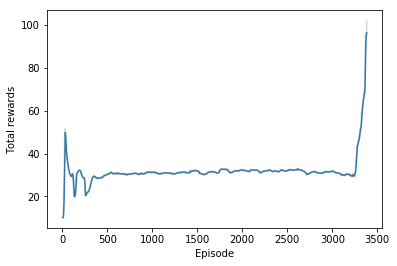

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

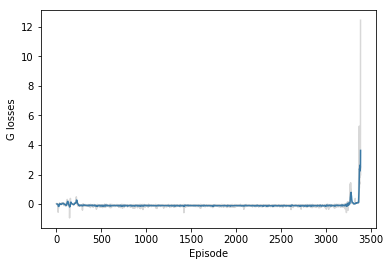

In [29]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

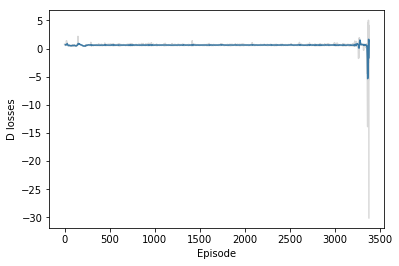

In [30]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [33]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 58.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.